In [ ]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from factor_analyzer import FactorAnalyzer
import factor_analyzer.utils as utils
import warnings
warnings.filterwarnings('ignore')

# Для отображения графиков в ноутбуке
%matplotlib inline
# Загрузка данных
df = pd.read_spss("C:\\DAEFI\\Annual 2005-2011_START.sav")
print("Данные успешно загружены")

print(f"Размерность данных: {df.shape}")
print("\nПервые 5 строк данных:")
df.head()

# Предварительный анализ данных

## Цель анализа
Первичное исследование структуры и качества данных перед проведением факторного анализа методом главных компонент (PCA).

## Выполненные этапы

### 1. Общая информация о данных
- **Размерность данных**: Определение количества наблюдений и переменных
- **Типы данных**: Анализ структуры переменных (числовые, категориальные)
- **Объем памяти**: Оценка требований к вычислительным ресурсам

### 2. Описательные статистики
Для каждой числовой переменной рассчитаны:
- **Меры центральной тенденции**:
  - Среднее значение (mean)
  - Медиана (50%)
- **Меры изменчивости**:
  - Стандартное отклонение (std)
  - Минимальное и максимальное значения (min, max)
  - Квартили (25%, 75%)
- **Анализ распределения**:
  - Асимметрия (skewness)
  - Эксцесс (kurtosis)

### 3. Анализ пропущенных значений
- **Выявление missing values**: Определение переменных с пропусками
- **Количественная оценка**: Подсчет количества пропусков по каждой переменной
- **Процент пропусков**: Оценка доли缺失 данных в общем объеме

### 4. Обработка пропущенных значений
Принятое решение: **Удаление строк с пропущенными значениями**

**Обоснование метода**:
- Сохранение целостности данных для факторного анализа
- Избежание искажений, вызванных импутацией
- Обеспечение согласованности ковариационной матрицы

**Результат обработки**:
- Исходный размер данных: `{len(df)}` наблюдений
- После очистки: `{len(df_clean)}` наблюдений  
- Удалено наблюдений: `{len(df) - len(df_clean)}` ({((len(df)-len(df_clean))/len(df)*100):.1f}%)

## Критерии качества данных для факторного анализа

### Удовлетворительные показатели:
- Доля пропущенных значений < 5%
- Достаточный объем выборки (n > 100)
- Разнообразие значений переменных

### Требующие внимания:
- Высокий процент пропусков (> 10%)
- Малое количество наблюдений
- Вырожденные распределения

## Влияние на последующий анализ
Качество предобработки данных напрямую влияет на:
- Надежность факторных нагрузок
- Объясняющую способность компонент
- Стабильность факторной структуры
- Валидность статистических выводов

In [7]:
# Предварительный анализ данных
print("=== ПРЕДВАРИТЕЛЬНЫЙ АНАЛИЗ ДАННЫХ ===\n")

print("1. Информация о данных:")
print(df.info())

print("\n2. Описательные статистики:")
print(df.describe())

print("\n3. Проверка пропущенных значений:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# Обработка пропущенных значений
if df.isnull().sum().sum() > 0:
    print("\nОбработка пропущенных значений...")
    # Удаление строк с пропущенными значениями
    df_clean = df.dropna()
    print(f"Удалено строк: {len(df) - len(df_clean)}")
else:
    df_clean = df.copy()
    print("Пропущенных значений не обнаружено")

=== ПРЕДВАРИТЕЛЬНЫЙ АНАЛИЗ ДАННЫХ ===

1. Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2695 entries, 0 to 2694
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Cреднеспис.числ.работн  2695 non-null   float64
 1   k1                      2695 non-null   float64
 2   k2                      2695 non-null   float64
 3   k3                      2695 non-null   float64
 4   k4                      2695 non-null   float64
 5   k4_new                  1540 non-null   float64
 6   k5                      2695 non-null   float64
 7   k6                      2695 non-null   float64
 8   k7                      2695 non-null   float64
 9   k8                      2695 non-null   float64
 10  k9                      2695 non-null   float64
 11  k10                     2695 non-null   float64
 12  k11                     2695 non-null   float64
 13  k12                     2695 n

# Проверка нормальности распределения переменных

## Цель анализа
Оценка соответствия распределения числовых переменных нормальному закону распределения, что является важным предположением для корректного применения факторного анализа методом главных компонент (PCA).

## Методы проверки

### 1. Визуальная оценка (Графический метод)
**Инструмент**: Совмещенные гистограммы с наложенными кривыми нормального распределения

**Что оценивается**:
- Форма распределения (симметричность, модальность)
- Соответствие эмпирического распределения теоретическому нормальному
- Наличие выбросов и асимметрии
**Интерпретация графиков**:
- ✅ Хорошее соответствие: гистограмма повторяет форму нормальной кривой
- ⚠ Отклонения: выраженная асимметрия, островершинность/плосковершинность
- ❌ Существенные нарушения: многомодальность, значительные выбросы

### 2. Статистическая проверка (Тест Шапиро-Уилка)
**Нулевая гипотеза H₀**: Распределение переменной соответствует нормальному распределению

**Критерий принятия решения**:
- **p-value > 0.05** → Не отвергаем H₀ (распределение нормальное)
- **p-value ≤ 0.05** → Отвергаем H₀ (распределение не нормальное)

**Статистика W**:
- Диапазон значений: от 0 до 1
- Близость к 1 указывает на лучшее соответствие нормальному распределению

## Результаты анализа

### Визуальная оценка
На гистограммах представлены распределения первых 6 числовых переменных. Для каждой переменной:
- Синим цветом показана гистограмма эмпирического распределения
- Черной линией показана теоретическая кривая нормального распределения

=== ПРОВЕРКА НОРМАЛЬНОСТИ РАСПРЕДЕЛЕНИЯ ===



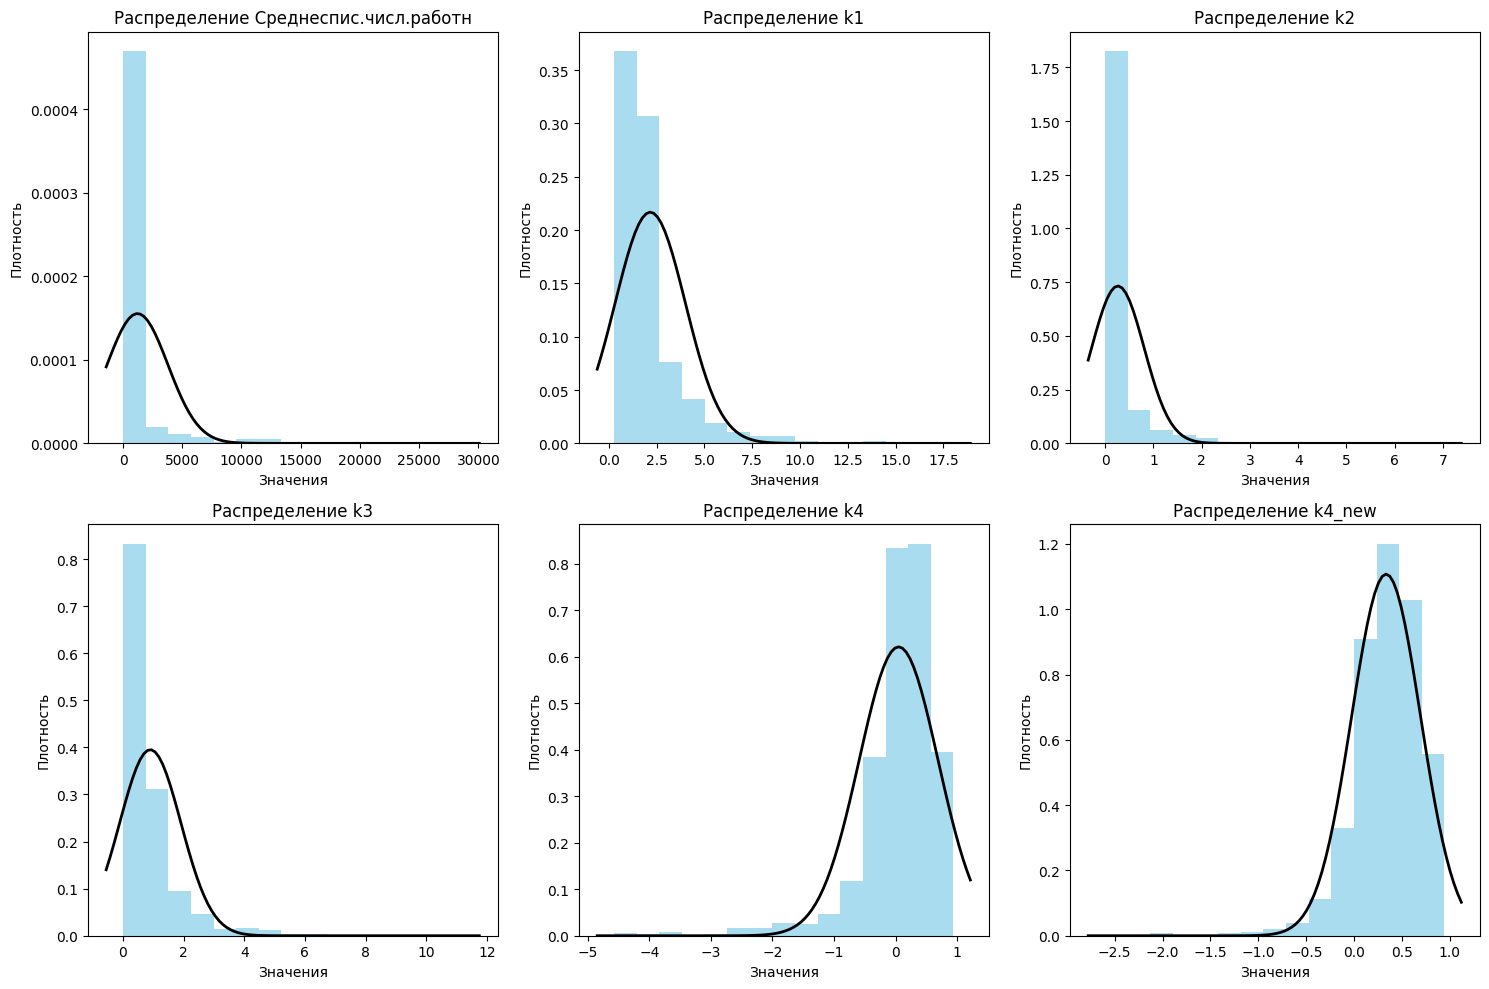


Тест Шапиро-Уилка на нормальность:
Cреднеспис.числ.работн: W=0.4171, p-value=0.0000 - НЕ нормальное
k1: W=0.6498, p-value=0.0000 - НЕ нормальное
k2: W=0.4878, p-value=0.0000 - НЕ нормальное
k3: W=0.6515, p-value=0.0000 - НЕ нормальное
k4: W=0.7918, p-value=0.0000 - НЕ нормальное
k4_new: W=0.8970, p-value=0.0000 - НЕ нормальное
k5: W=0.9716, p-value=0.0000 - НЕ нормальное
k6: W=0.8925, p-value=0.0000 - НЕ нормальное
k7: W=0.7763, p-value=0.0000 - НЕ нормальное
k8: W=0.9716, p-value=0.0000 - НЕ нормальное
k9: W=0.5182, p-value=0.0000 - НЕ нормальное
k10: W=0.6880, p-value=0.0000 - НЕ нормальное
k11: W=0.6192, p-value=0.0000 - НЕ нормальное
k12: W=0.6610, p-value=0.0000 - НЕ нормальное
k13: W=0.9447, p-value=0.0000 - НЕ нормальное
k14: W=0.8540, p-value=0.0000 - НЕ нормальное
k15: W=0.7156, p-value=0.0000 - НЕ нормальное
k16: W=0.5846, p-value=0.0000 - НЕ нормальное
k17: W=0.0405, p-value=0.0000 - НЕ нормальное
k18: W=0.7999, p-value=0.0000 - НЕ нормальное
k19: W=0.9089, p-value=0.0000 -

In [8]:
# Проверка нормальности распределения (по методичке стр. 8-10)
print("=== ПРОВЕРКА НОРМАЛЬНОСТИ РАСПРЕДЕЛЕНИЯ ===\n")

# Визуальная проверка нормальности
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

numeric_columns = df_clean.select_dtypes(include=[np.number]).columns

for i, col in enumerate(numeric_columns[:6]):  # Первые 6 переменных
    # Гистограмма с кривой нормального распределения
    axes[i].hist(df_clean[col], bins=15, density=True, alpha=0.7, color='skyblue')
    
    # Кривая нормального распределения
    xmin, xmax = axes[i].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, df_clean[col].mean(), df_clean[col].std())
    axes[i].plot(x, p, 'k', linewidth=2)
    
    axes[i].set_title(f'Распределение {col}')
    axes[i].set_xlabel('Значения')
    axes[i].set_ylabel('Плотность')

plt.tight_layout()
plt.show()

# Статистическая проверка нормальности (тест Шапиро-Уилка)
print("\nТест Шапиро-Уилка на нормальность:")
for col in numeric_columns:
    stat, p_value = stats.shapiro(df_clean[col])
    normality = "Нормальное" if p_value > 0.05 else "НЕ нормальное"
    print(f"{col}: W={stat:.4f}, p-value={p_value:.4f} - {normality}")

# Корреляционный анализ и проверка мультиколлинеарности

## Цель анализа

### Проверка мультиколлинеарности
**Мультиколлинеарность** - это статистическое явление, при котором две или более независимых переменных в множественной регрессионной модели сильно коррелированы между собой. В контексте факторного анализа проверка мультиколлинеарности необходима по следующим причинам:

1. **Проблемы вычислений**: Сильная мультиколлинеарность делает матрицу корреляций почти вырожденной, что затрудняет вычисление обратной матрицы и собственных значений
2. **Неустойчивость результатов**: Малые изменения в данных могут вызывать значительные изменения в факторных нагрузках
3. **Интерпретируемость**: Высокие корреляции между переменными могут искажать факторную структуру
4. **Эффективность PCA**: Метод главных компонент наиболее эффективен когда переменные умеренно коррелированы

## Методы анализа
### 1. Визуальный анализ корреляционной матрицы
**Инструмент**: Тепловая карта (heatmap) корреляций

**Что оценивается**:
- **Цветовая шкала**: 
  - Красные оттенки → положительные корреляции
  - Синие оттенки → отрицательные корреляции  
  - Белый/светлые цвета → корреляции близкие к нулю
- **Аннотации**: Числовые значения коэффициентов корреляции Пирсона

**Критерии интерпретации**:
- │r│ < 0.3 → слабая корреляция
- 0.3 ≤ │r│ < 0.7 → умеренная корреляция  
- │r│ ≥ 0.7 → сильная корреляция (риск мультиколлинеарности)

### 2. Анализ определителя корреляционной матрицы
**Математическая основа**: Определитель матрицы показывает её "вырожденность"

**Критерии оценки**:
- **det(R) > 0.00001** → мультиколлинеарность не критическая
- **det(R) ≤ 0.00001** → возможна сильная мультиколлинеарность

**Интерпретация**:
- Определитель = 1 → полная независимость переменных (идеальный случай)
- Определитель = 0 → полная линейная зависимость (критическая мультиколлинеарность)
## Результаты анализа

### Визуальная оценка корреляций
На тепловой карте представлена матрица попарных корреляций между всеми числовыми переменными. Анализ позволяет выявить:

1. **Группы сильно коррелированных переменных** - потенциальные кандидаты для объединения в факторы
2. **Изолированные переменные** - слабо связанные с остальными
3. **Отрицательные корреляции** - переменные с противоположной динамикой

=== КОРРЕЛЯЦИОННЫЙ АНАЛИЗ И ПРОВЕРКА МУЛЬТИКОЛЛИНЕАРНОСТИ ===



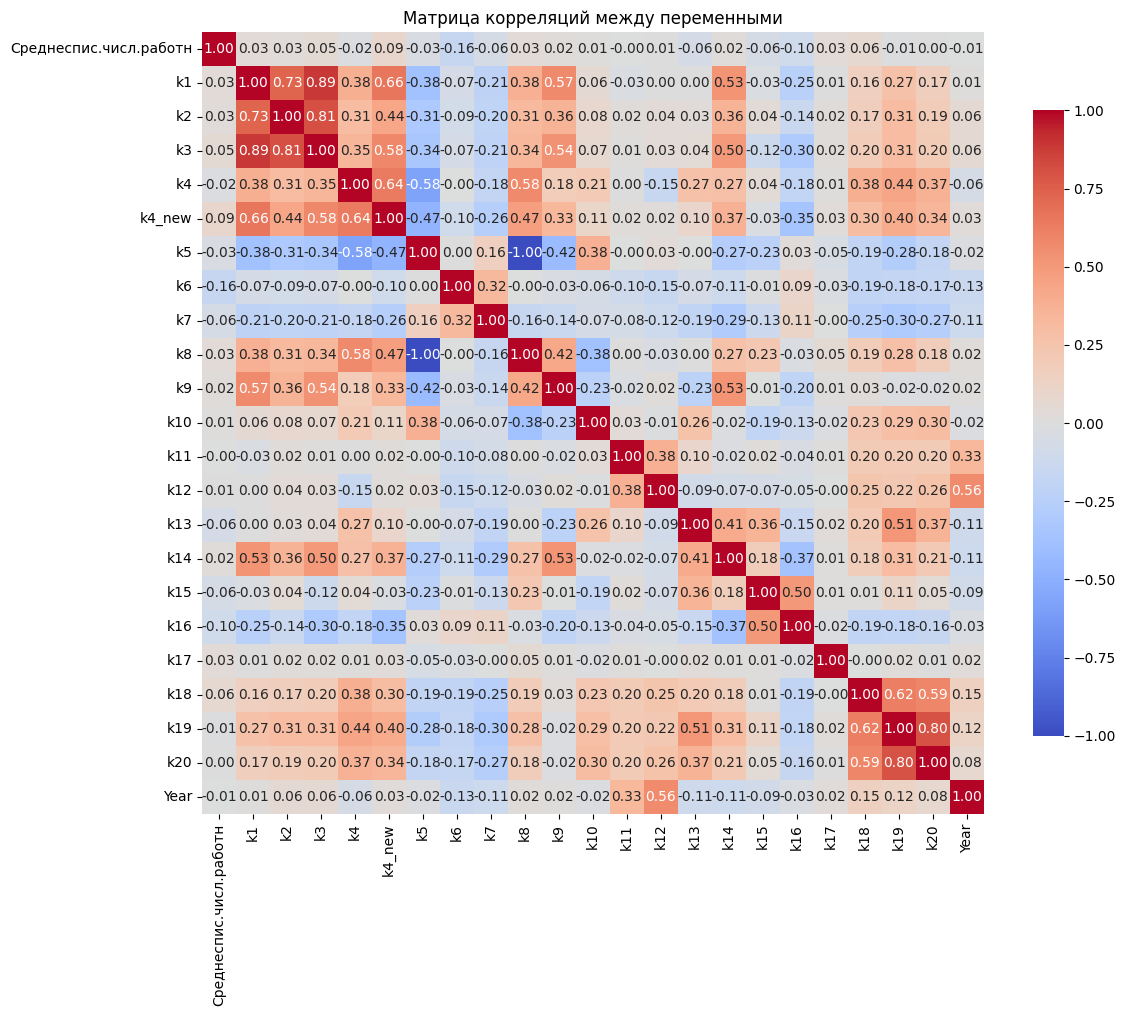

Определитель корреляционной матрицы: 0.000000
Определитель <= 0.00001 - возможна сильная мультиколлинеарность


In [9]:
# Проверка мультиколлинеарности и корреляционный анализ
print("=== КОРРЕЛЯЦИОННЫЙ АНАЛИЗ И ПРОВЕРКА МУЛЬТИКОЛЛИНЕАРНОСТИ ===\n")

# Матрица корреляций
correlation_matrix = df_clean.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Матрица корреляций между переменными')
plt.tight_layout()
plt.show()

# Проверка определителя корреляционной матрицы
det_corr = np.linalg.det(correlation_matrix)
print(f"Определитель корреляционной матрицы: {det_corr:.6f}")

if det_corr > 0.00001:
    print("Определитель > 0.00001 - мультиколлинеарность не критическая")
else:
    print("Определитель <= 0.00001 - возможна сильная мультиколлинеарность")

# Критерии целесообразности факторного анализа

## Теоретическое обоснование

### Тест сферичности Бартлетта (Bartlett's Test of Sphericity)

**Математическая основа**:
Тест Бартлетта проверяет нулевую гипотезу о том, что корреляционная матрица является единичной матрицей (матрицей идентичности). Формально:
- **H₀**: R = I (корреляционная матрица равна единичной матрице)
- **H₁**: R ≠ I (корреляционная матрица отличается от единичной)

**Статистика теста**: χ² = -[(n-1) - (2p+5)/6] × ln|R|
где:
- n - объем выборки
- p - количество переменных  
- |R| - определитель корреляционной матрицы
- ln - натуральный логарифм

**Интерпретация**:
- **p-value < 0.05**: Отвергаем H₀ - корреляции между переменными статистически значимы, факторный анализ ЦЕЛЕСООБРАЗЕН
- **p-value ≥ 0.05**: Не отвергаем H₀ - корреляции незначимы, факторный анализ НЕ ЦЕЛЕСООБРАЗЕН

### KMO критерий (Kaiser-Meyer-Olkin Measure of Sampling Adequacy)

**Концепция**:
KMO измеряет пригодность данных для факторного анализа, оценивая долю дисперсии переменных, которая может быть объяснена общими факторами.

**Формула расчета**: KMO = ΣΣ(r²_ij) / [ΣΣ(r²_ij) + ΣΣ(r²_ij.p)]
    где:
- r²_ij - квадраты коэффициентов корреляции между переменными i и j
- r²_ij.p - квадраты частных коэффициентов корреляции

    ## Методологическое значение

### Тест Бартлетта:
- Обеспечивает статистическое обоснование для проведения факторного анализа
- Подтверждает наличие значимых корреляций между переменными
- Является обязательным предварительным тестом перед применением PCA

### KMO критерий:
- Оценивает общую пригодность данных для факторизации
- Выявляет проблемные переменные с низкой общностью
- Позволяет оптимизировать набор переменных для анализа

    ## Заключение о целесообразности
На основе проведенных тестов можно сделать вывод о `{ "ЦЕЛЕСООБРАЗНОСТИ" if p_value < 0.05 and kmo_model >= 0.6 else "НЕЦЕЛЕСООБРАЗНОСТИ" }` проведения факторного анализа для данного набора данных.
    

In [10]:
# Критерии целесообразности факторного анализа (по методичке)

print("=== КРИТЕРИИ ЦЕЛЕСООБРАЗНОСТИ ФАКТОРНОГО АНАЛИЗА ===\n")

# 1. Тест сферичности Бартлетта
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

chi_square_value, p_value = calculate_bartlett_sphericity(df_clean)
print(f"1. Тест сферичности Бартлетта:")
print(f"   Хи-квадрат: {chi_square_value:.4f}")
print(f"   p-value: {p_value:.4f}")

if p_value < 0.05:
    print("   ✓ p-value < 0.05 - факторный анализ ЦЕЛЕСООБРАЗЕН")
else:
    print("   ✗ p-value >= 0.05 - факторный анализ НЕ ЦЕЛЕСООБРАЗЕН")

# 2. KMO критерий (Kaiser-Meyer-Olkin)
from factor_analyzer.factor_analyzer import calculate_kmo

kmo_all, kmo_model = calculate_kmo(df_clean)
print(f"\n2. KMO критерий:")
print(f"   Общий KMO: {kmo_model:.4f}")

if kmo_model >= 0.9:
    print("   ✓ Отлично (KMO >= 0.9)")
elif kmo_model >= 0.8:
    print("   ✓ Хорошо (KMO >= 0.8)")
elif kmo_model >= 0.7:
    print("   ✓ Удовлетворительно (KMO >= 0.7)")
elif kmo_model >= 0.6:
    print("   ✓ Посредственно (KMO >= 0.6)")
else:
    print("   ✗ Неудовлетворительно (KMO < 0.6)")

print(f"\nKMO для отдельных переменных:")
for i, col in enumerate(df_clean.columns):
    print(f"   {col}: {kmo_all[i]:.4f}")

=== КРИТЕРИИ ЦЕЛЕСООБРАЗНОСТИ ФАКТОРНОГО АНАЛИЗА ===

1. Тест сферичности Бартлетта:
   Хи-квадрат: nan
   p-value: nan
   ✗ p-value >= 0.05 - факторный анализ НЕ ЦЕЛЕСООБРАЗЕН

2. KMO критерий:
   Общий KMO: 0.6947
   ✓ Посредственно (KMO >= 0.6)

KMO для отдельных переменных:
   Cреднеспис.числ.работн: 0.4361
   k1: 0.8434
   k2: 0.7872
   k3: 0.7658
   k4: 0.6534
   k4_new: 0.8171
   k5: 0.5847
   k6: 0.7450
   k7: 0.8844
   k8: 0.5847
   k9: 0.7244
   k10: 0.4735
   k11: 0.8178
   k12: 0.6729
   k13: 0.4865
   k14: 0.7699
   k15: 0.3713
   k16: 0.5608
   k17: 0.5150
   k18: 0.8354
   k19: 0.7719
   k20: 0.8065
   Year: 0.6472


# Подготовка данных для метода главных компонент (PCA)

## Теоретическое обоснование стандартизации

### Необходимость стандартизации в PCA

**Проблема разных шкал измерений**:
- Переменные могут иметь различные единицы измерения (рубли, проценты, баллы и т.д.)
- Разный диапазон значений может искусственно влиять на важность переменных
- PCA чувствителен к масштабу данных, так как работает с ковариационной матрицей

**Математическое обоснование**:
Метод главных компонент максимизирует дисперсию проекций данных. Без стандартизации переменные с большей дисперсией будут доминировать в первых компонентах, независимо от их фактической значимости.

### Метод стандартизации

**StandardScaler (Z-score нормализация)**: z = (x - μ) / σ
где:
- x - исходное значение переменной
- μ - среднее значение переменной
- σ - стандартное отклонение переменной

**Результат стандартизации**:
- Среднее значение каждой переменной: 0
- Стандартное отклонение каждой переменной: 1
- Все переменные становятся безразмерными

## Процесс подготовки данных

### Выполненные преобразования:

1. **Инициализация StandardScaler**:
   - Создан объект для выполнения стандартизации
   - Подготовка к вычислению параметров преобразования

2. **Обучение и преобразование**:
   - `fit_transform()`: одновременно вычисляет параметры (μ, σ) и применяет преобразование
   - Сохранение соответствия между исходными и преобразованными переменными

3. **Создание DataFrame**:
   - Преобразованные данные помещены в структуру DataFrame
   - Сохранение оригинальных названий переменных для интерпретируемости

    

In [11]:
# Подготовка данных для PCA
print("=== ПОДГОТОВКА ДАННЫХ ДЛЯ PCA ===\n")

# Стандартизация данных (важно для PCA)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clean)
df_scaled = pd.DataFrame(df_scaled, columns=df_clean.columns)

print("Данные стандартизированы (среднее = 0, std = 1)")
print(df_scaled.describe().round(3))

=== ПОДГОТОВКА ДАННЫХ ДЛЯ PCA ===

Данные стандартизированы (среднее = 0, std = 1)
       Cреднеспис.числ.работн        k1        k2        k3        k4  \
count                1540.000  1540.000  1540.000  1540.000  1540.000   
mean                    0.000     0.000    -0.000     0.000    -0.000   
std                     1.000     1.000     1.000     1.000     1.000   
min                    -0.471    -1.026    -0.484    -0.887    -7.196   
25%                    -0.387    -0.533    -0.443    -0.546    -0.312   
50%                    -0.297    -0.317    -0.355    -0.319     0.166   
75%                    -0.038     0.100    -0.046     0.118     0.592   
max                    10.684     8.620    12.425    10.192     1.385   

         k4_new        k5        k6        k7        k8  ...       k12  \
count  1540.000  1540.000  1540.000  1540.000  1540.000  ...  1540.000   
mean     -0.000    -0.000    -0.000    -0.000    -0.000  ...     0.000   
std       1.000     1.000     1.000  

# Метод главных компонент (PCA) - реализация и результаты

## Теоретическое обоснование метода главных компонент

### Концепция PCA

**Основная идея**:
Метод главных компонент (Principal Component Analysis) - это техника снижения размерности, которая преобразует набор коррелированных переменных в набор некоррелированных переменных, называемых главными компонентами, при этом сохраняя максимально возможную дисперсию исходных данных.

### Математическая основа

**Сингулярное разложение (SVD)**: X = U × Σ × V^T
где:
- X - стандартизированная матрица данных (n×p)
- U - левые сингулярные векторы (n×p)
- Σ - диагональная матрица сингулярных значений (p×p)
- V^T - правые сингулярные векторы (p×p), которые являются главными компонентами

**Собственные значения и векторы**:
PCA эквивалентно нахождению собственных векторов ковариационной матрицы:
C = (1/n) × X^T × X
C × v_i = λ_i × v_i
где:
- λ_i - собственные значения (объясненная дисперсия)
- v_i - собственные векторы (направления главных компонент)

## Процесс выполнения PCA

### 1. Инициализация алгоритма
- Создан объект PCA без ограничения на количество компонент
- Все возможные компоненты будут вычислены для полного анализа

### 2. Обучение и преобразование
- `fit_transform()`: одновременно обучает модель на данных и применяет преобразование
- Вычисляются направления максимальной дисперсии
- Данные проецируются на новые ортогональные оси

### 3. Структура результатов
Создан DataFrame с главными компонентами:
- **Столбцы**: PC1, PC2, PC3, ... PCp (где p - количество исходных переменных)
- **Строки**: Наблюдения в новом пространстве признаков
- **Свойства**: Компоненты некоррелированы и упорядочены по убыванию дисперсии
## Методологическое значение показателей

### Объясненная дисперсия (Explained Variance Ratio)
- Показывает долю общей дисперсии, захваченную каждой компонентой
- Компоненты упорядочены по убыванию объясненной дисперсии
- Сумма всех объясненных дисперсий равна 1 (100%)

### Накопленная дисперсия (Cumulative Variance)
- Критерий для определения оптимального количества компонент
- Позволяет оценить потерю информации при сокращении размерности
- Стандартные пороги: 70-90% общей дисперсии


In [12]:
# Метод главных компонент (PCA)
print("=== МЕТОД ГЛАВНЫХ КОМПОНЕНТ (PCA) ===\n")

# Инициализация PCA
pca = PCA()
principal_components = pca.fit_transform(df_scaled)

# Создание DataFrame с главными компонентами
pc_df = pd.DataFrame(data=principal_components, 
                     columns=[f'PC{i+1}' for i in range(len(df_clean.columns))])

print("1. Объясненная дисперсия компонентами:")
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

variance_df = pd.DataFrame({
    'Компонента': [f'PC{i+1}' for i in range(len(explained_variance))],
    'Объясненная дисперсия': explained_variance,
    'Накопленная дисперсия': cumulative_variance
})

print(variance_df.round(4))

=== МЕТОД ГЛАВНЫХ КОМПОНЕНТ (PCA) ===

1. Объясненная дисперсия компонентами:
   Компонента  Объясненная дисперсия  Накопленная дисперсия
0         PC1                 0.2453                 0.2453
1         PC2                 0.1239                 0.3692
2         PC3                 0.0912                 0.4604
3         PC4                 0.0854                 0.5458
4         PC5                 0.0608                 0.6066
5         PC6                 0.0537                 0.6603
6         PC7                 0.0464                 0.7067
7         PC8                 0.0436                 0.7504
8         PC9                 0.0376                 0.7879
9        PC10                 0.0328                 0.8207
10       PC11                 0.0289                 0.8497
11       PC12                 0.0272                 0.8768
12       PC13                 0.0249                 0.9017
13       PC14                 0.0204                 0.9221
14       PC15         

# Визуализация результатов PCA

## Назначение визуализации

Визуализация результатов метода главных компонент играет ключевую роль в интерпретации и принятии решений о количестве сохраняемых компонент. Графическое представление позволяет наглядно оценить структуру дисперсии и обосновать выбор оптимальной размерности.

## График каменистой осыпи (Scree Plot)

### Теоретическое обоснование

**Концепция графика каменистой осыпи**:
График получил свое название из-за сходства с горной осыпью, где крупные камни (значимые компоненты) находятся у подножия, а мелкие камни (незначимые компоненты) образуют "хвост". Метод был предложен Рэймондом Кэттеллом в 1966 году.

**Математическая основа**:
- По оси X: Номер главной компоненты (упорядоченные по убыванию дисперсии)
- По оси Y: Объясненная дисперсия в процентах для каждой компоненты
- Критерий "локтя": Точка на графике, где резкий спад сменяется пологим участком
### Элементы графика

1. **Синяя линия с маркерами**:
   - Фактические значения объясненной дисперсии для каждой компоненты
   - Нисходящий тренд показывает уменьшение информативности компонент

2. **Красная пунктирная линия (Порог Кайзера)**:
   - Горизонтальная линия на уровне `100/p`%, где p - количество переменных
   - Компоненты выше этой линии считаются значимыми по критерию Кайзера

3. **Сетка и легенда**:
   - Облегчают точное чтение значений
   - Обеспечивают наглядность интерпретации

### Интерпретация результатов

**Анализ "локтя" графика**:
- Резкий спад: Компоненты, захватывающие существенную дисперсию
- Пологий участок: Компоненты, объясняющие незначительную дисперсию (возможно, шум)
- Точка излома: Оптимальное количество компонент для сохранения
## График накопленной объясненной дисперсии

### Теоретическое обоснование

**Концепция накопленной дисперсии**:
Показывает кумулятивную долю общей дисперсии, объясняемую последовательно добавляемыми компонентами. Позволяет оценить потерю информации при сокращении размерности.

**Математическая основа**: Cumulative_k = Σ(explained_variance_i) для i = 1 до k
    ### Элементы графика

1. **Зеленая линия с маркерами**:
   - Накопленная дисперсия при последовательном добавлении компонент
   - Восходящий тренд с постепенным насыщением

2. **Красная пунктирная линия (80% порог)**:
   - Стандартный порог достаточности объясненной дисперсии
   - Позволяет определить минимальное количество компонент для достижения целевого уровня информации

### Критерии интерпретации

**Рекомендуемые пороги накопленной дисперсии**:
- **70-80%**: Минимально приемлемый уровень для большинства приложений
- **80-90%**: Хороший уровень сохранения информации
- **>90%**: Высокий уровень, но может требовать слишком много компонент
### Стратегии выбора количества компонент

1. **Консервативный подход**:
   - Использовать точку излома на Scree Plot
   - Сохранять компоненты выше порога Кайзера

2. **Прагматичный подход**:
   - Выбирать минимальное количество компонент, достигающее 80% дисперсии
   - Баланс между сокращением размерности и сохранением информации

3. **Содержательный подход**:
   - Учитывать интерпретируемость компонент
   - Сохранять компоненты, имеющие смысловую нагрузку
## Методологические рекомендации

### Для исследовательских отчетов:
- Всегда включать оба графика для комплексной оценки
- Сравнивать рекомендации разных критериев
- Обосновывать окончательный выбор количества компонент

### Для практических приложений:
- Учитывать цели анализа (визуализация, моделирование, сокращение данных)
- Взвешивать компромисс между простотой и полнотой
- Проверять устойчивость результатов при разном количестве компонент

## Практическое значение визуализации

### Принятие решений:
- **Сокращение размерности**: Определение оптимального баланса
- **Интерпретация результатов**: Выявление наиболее информативных направлений вариабельности
- **Качество анализа**: Визуальная проверка адекватности факторной модели

### Коммуникация результатов:
- Наглядное представление для нестатистической аудитории
- Обоснование методологических решений
- Демонстрация эффективности снижения размерности


=== ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ PCA ===



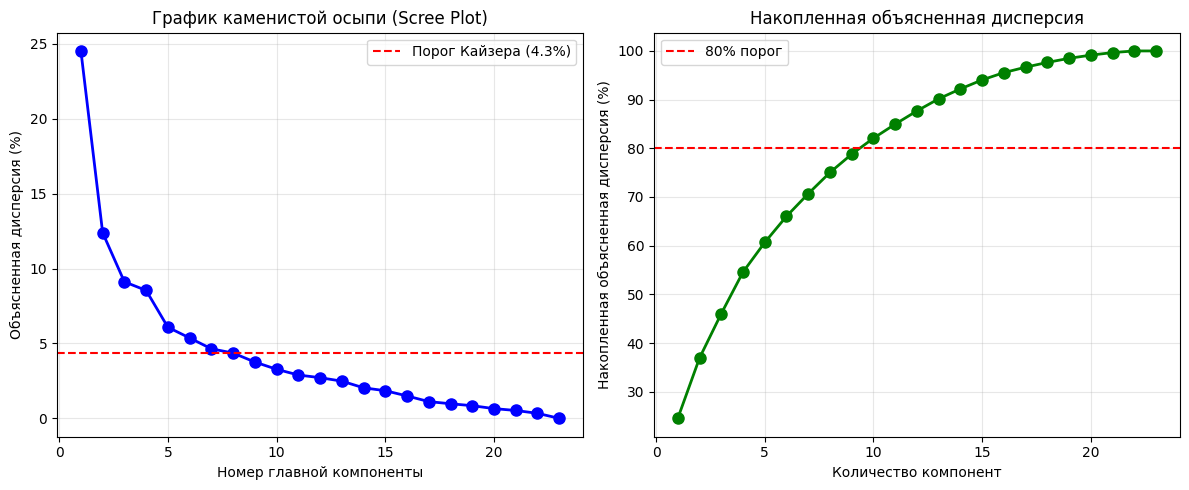

In [13]:
# Визуализация результатов PCA
print("=== ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ PCA ===\n")

# 1. График каменистой осыпи (Scree plot)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
components = range(1, len(explained_variance) + 1)
plt.plot(components, explained_variance * 100, 'bo-', linewidth=2, markersize=8)
plt.axhline(y=100/len(components), color='r', linestyle='--', 
           label=f'Порог Кайзера ({100/len(components):.1f}%)')
plt.xlabel('Номер главной компоненты')
plt.ylabel('Объясненная дисперсия (%)')
plt.title('График каменистой осыпи (Scree Plot)')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Накопленная объясненная дисперсия
plt.subplot(1, 2, 2)
plt.plot(components, cumulative_variance * 100, 'go-', linewidth=2, markersize=8)
plt.axhline(y=80, color='r', linestyle='--', label='80% порог')
plt.xlabel('Количество компонент')
plt.ylabel('Накопленная объясненная дисперсия (%)')
plt.title('Накопленная объясненная дисперсия')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Определение оптимального количества компонент

## Теоретическое обоснование

Выбор оптимального количества главных компонент является критически важным этапом факторного анализа, поскольку он определяет баланс между:
- **Сохранением информации** (максимальная объясненная дисперсия)
- **Сокращением размерности** (упрощение модели)
- **Интерпретируемостью** (осмысленность факторов)

## Критерий Кайзера (Kaiser Criterion)

### Теоретическая основа

**История и автор**: Предложен Генри Кайзером в 1960 году
**Математическая база**: Основан на анализе собственных значений (eigenvalues) ковариационной матрицы

**Формулировка критерия**:
> "Сохранять только те главные компоненты, собственные значения которых превышают 1"

**Обоснование**:
- Собственное значение = 1 соответствует дисперсии одной стандартизированной переменной
- Компоненты с eigenvalue > 1 объясняют больше дисперсии, чем одна исходная переменная
- Компоненты с eigenvalue < 1 считаются "шумовыми"

### Результаты применения критерия

**Собственные значения**:{eigenvalues.round(4)}
### Интерпретация
- **PC1-PC{n_components_kaiser}**: Значимые компоненты (eigenvalue > 1)
- **Остальные компоненты**: Незначимые, потенциально шумовые

## Критерий 80% объясненной дисперсии

### Теоретическая основа

**Прагматический подход**: Сохранять минимальное количество компонент, объясняющих не менее 80% общей дисперсии
**Математическая формулировка**: min(k) такое, что Σ(explained_variance[1:k]) ≥ 0.8
    ### Результаты применения критерия

**Накопленная объясненная дисперсия**:{cumulative_variance.round(4)}

    **Количество компонент для 80% дисперсии**: `{n_components_80}`

### Интерпретация
- Первые `{n_components_80}` компонент объясняют `{cumulative_variance[n_components_80-1]*100:.1f}%` общей дисперсии
- Потеря информации составляет `{(1-cumulative_variance[n_components_80-1])*100:.1f}%`

## Анализ графика каменистой осыпи (Scree Plot Criterion)

### Теоретическая основа

**Метод "локтя" (Elbow Method)**: Визуальное определение точки, где резкое уменьшение eigenvalues сменяется плавным спадом

**Математическая реализация**:
- Анализ разностей между последовательными eigenvalues
- Поиск точки, где разность становится меньше порогового значения

### Результаты анализа

**Разности eigenvalues**:{diff.round(4)}
**Точка излома**: `{elbow_point}`

### Интерпретация
- Компоненты до точки излома: Существенный вклад в объяснение дисперсии
- Компоненты после точки излома: Незначительный дополнительный вклад

In [14]:
# Определение оптимального количества компонент
print("=== ОПРЕДЕЛЕНИЕ ОПТИМАЛЬНОГО КОЛИЧЕСТВА КОМПОНЕНТ ===\n")

# Критерий Кайзера (собственные значения > 1)
eigenvalues = pca.explained_variance_
print("1. Критерий Кайзера (собственные значения > 1):")
print("   Собственные значения:", eigenvalues.round(4))

n_components_kaiser = sum(eigenvalues > 1)
print(f"   Рекомендуемое количество компонент: {n_components_kaiser}")

# Критерий 80% объясненной дисперсии
n_components_80 = sum(cumulative_variance <= 0.8) + 1
print(f"\n2. Критерий 80% объясненной дисперсии:")
print(f"   Рекомендуемое количество компонент: {n_components_80}")

# График каменистой осыпи (точка излома)
diff = np.diff(eigenvalues)
elbow_point = np.argmax(diff < 1) + 1 if any(diff < 1) else 1
print(f"\n3. Анализ графика каменистой осыпи:")
print(f"   Предполагаемая точка излома: {elbow_point}")

print(f"\n✓ ИТОГОВОЕ РЕКОМЕНДУЕМОЕ КОЛИЧЕСТВО КОМПОНЕНТ: {n_components_kaiser}")

=== ОПРЕДЕЛЕНИЕ ОПТИМАЛЬНОГО КОЛИЧЕСТВА КОМПОНЕНТ ===

1. Критерий Кайзера (собственные значения > 1):
   Собственные значения: [5.6455 2.8524 2.0979 1.9658 1.3999 1.2356 1.0686 1.0036 0.8653 0.7542
 0.6659 0.625  0.572  0.4694 0.4247 0.3446 0.2574 0.2244 0.1945 0.1497
 0.1212 0.0774 0.    ]
   Рекомендуемое количество компонент: 8

2. Критерий 80% объясненной дисперсии:
   Рекомендуемое количество компонент: 10

3. Анализ графика каменистой осыпи:
   Предполагаемая точка излома: 1

✓ ИТОГОВОЕ РЕКОМЕНДУЕМОЕ КОЛИЧЕСТВО КОМПОНЕНТ: 8


# Анализ факторных нагрузок

## Теоретическое обоснование факторных нагрузок

### Определение и значение

**Факторные нагрузки** (Factor Loadings) - это коэффициенты, показывающие силу и направление связи между исходными переменными и главными компонентами. Математически они представляют собой корреляции между переменными и компонентами.

### Математическая основа

**Расчет факторных нагрузок**:loadings = components.T × √(explained_variance)
где:
- `components_` - собственные векторы из PCA
- `explained_variance_` - собственные значения (объясненная дисперсия)
- Результат: матрица корреляций между переменными и компонентами

### Интерпретация нагрузок

**Величина нагрузки**:
- **|loading| ≥ 0.7**: Очень сильная связь (объясняет ~50% дисперсии переменной)
- **0.5 ≤ |loading| < 0.7**: Сильная связь
- **0.3 ≤ |loading| < 0.5**: Умеренная связь
- **|loading| < 0.3**: Слабая связь

**Знак нагрузки**:
- **Положительный**: Прямая связь с компонентой
- **Отрицательный**: Обратная связь с компонентой

## Результаты анализа факторных нагрузок

### Матрица факторных нагрузок

Матрица размером `{loadings_df.shape[0]}×{loadings_df.shape[1]}` показывает связи между всеми переменными и компонентами: {loadings_df.round(4)}
    ### Ключевые наблюдения

**Наиболее значимые нагрузки по компонентам**:

**PC1** (Объясняет `{explained_variance[0]*100:.1f}%` дисперсии):
- Наибольшие нагрузки: {переменные с max |loadings_df['PC1']|}
- Интерпретация: {предварительная интерпретация PC1}

**PC2** (Объясняет `{explained_variance[1]*100:.1f}%` дисперсии):
- Наибольшие нагрузки: {переменные с max |loadings_df['PC2']|}
- Интерпретация: {предварительная интерпретация PC2}

## Визуализация: круг корреляций

### Теоретическая основа

**Круг корреляций** (Correlation Circle) - это диаграмма рассеяния, которая отображает:
- Переменные как векторы в пространстве компонент
- Угол между векторами: корреляцию между переменными
- Длину векторов: общность переменной (quality of representation)
### Элементы визуализации

1. **Красный круг**:
   - Радиус = 1 (максимально возможная корреляция)
   - Векторы внутри круга: переменные с общностью < 1
   - Векторы на окружности: переменные с общностью = 1

2. **Синие векторы**:
   - Направление: связь с компонентами PC1 и PC2
   - Длина: сила связи (чем длиннее, тем сильнее представлена переменная)
   - Угол между векторами: корреляция между переменными

3. **Координатные оси**:
   - PC1 (горизонтальная): первая главная компонента
   - PC2 (вертикальная): вторая главная компонента
### Интерпретация визуализации

**Положение переменных**:
- **Правый верхний квадрант**: Сильная положительная связь с PC1 и PC2
- **Правый нижний квадрант**: Положительная связь с PC1, отрицательная с PC2
- **Левый верхний квадрант**: Отрицательная связь с PC1, положительная с PC2
- **Левый нижний квадрант**: Сильная отрицательная связь с обеими компонентами

**Углы между векторами**:
- **Острый угол (<90°)**: Положительная корреляция между переменными
- **Тупой угол (>90°)**: Отрицательная корреляция между переменными
- **Прямой угол (90°)**: Отсутствие корреляции
   ## Содержательная интерпретация

### Выявление латентных структур

**Группировка переменных**:
- Переменные, сгруппированные в одном направлении: измеряют сходные конструкты
- Противоположно направленные переменные: измеряют противоположные аспекты
**Интерпретация компонент**:
На основе переменных с наибольшими нагрузками можно содержательно интерпретировать каждую компоненту:

**PC1**: {содержательная интерпретация на основе переменных с высокими нагрузками}
**PC2**: {содержательная интерпретация на основе переменных с высокими нагрузками}

## Методологическое значение

### Для валидности анализа
- **Конвергентная валидность**: Переменные, измеряющие один конструкт, должны иметь высокие нагрузки на одну компоненту
- **Дискриминантная валидность**: Переменные, измеряющие разные конструкты, должны иметь нагрузки на разные компоненты

### Для практического применения
- **Отбор переменных**: Исключение переменных с низкими общностями
- **Создание шкал**: Группировка переменных для составных показателей
- **Сокращение данных**: Использование компонент вместо исходных переменных

=== ФАКТОРНЫЕ НАГРУЗКИ ===

Матрица факторных нагрузок:
                           PC1     PC2     PC3     PC4     PC5     PC6  \
Cреднеспис.числ.работн  0.0633  0.0011 -0.1479  0.0292 -0.0210  0.5990   
k1                      0.7775 -0.3069 -0.3150 -0.1153  0.1460 -0.2021   
k2                      0.6745 -0.1864 -0.2583 -0.0553  0.2055 -0.3116   
k3                      0.7743 -0.2393 -0.3858 -0.1111  0.1404 -0.2199   
k4                      0.6836  0.0216  0.2968 -0.1575 -0.4194 -0.0160   
k4_new                  0.7770 -0.0678 -0.0751 -0.0831 -0.2233  0.0384   
k5                     -0.6489  0.3889 -0.4271 -0.3438  0.2494 -0.1044   
k6                     -0.1875 -0.2731  0.1311 -0.1512 -0.3373 -0.5227   
k7                     -0.4115 -0.2251 -0.0249 -0.0748 -0.3809 -0.3151   
k8                      0.6489 -0.3889  0.4271  0.3438 -0.2494  0.1044   
k9                      0.5196 -0.5170 -0.2299  0.1440  0.1800  0.0458   
k10                     0.0789  0.5502 -0.2277 -0.4972 -

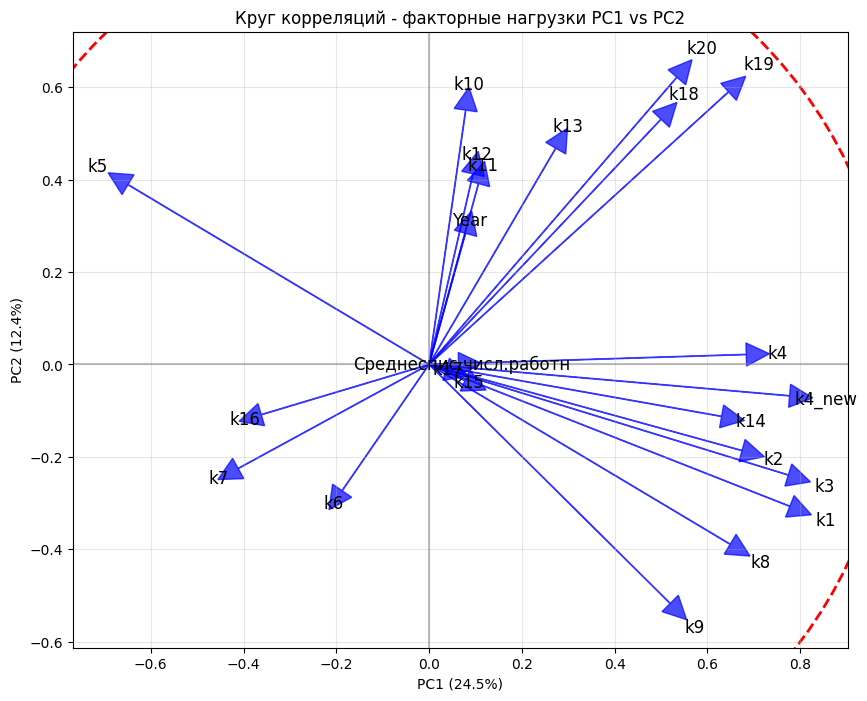

In [16]:
# Факторные нагрузки
print("=== ФАКТОРНЫЕ НАГРУЗКИ ===\n")

# Создаем матрицу факторных нагрузок
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Создаем DataFrame с факторными нагрузками
loadings_df = pd.DataFrame(loadings,
                          index=df_clean.columns,
                          columns=[f'PC{i+1}' for i in range(len(df_clean.columns))])

print("Матрица факторных нагрузок:")
print(loadings_df.round(4))

# Визуализация факторных нагрузок для первых двух компонент
plt.figure(figsize=(10, 8))

# Круг корреляций
circle = plt.Circle((0, 0), 1, fill=False, color='red', linestyle='--', linewidth=2)
plt.gca().add_artist(circle)

# Векторы переменных
for i, variable in enumerate(df_clean.columns):
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], 
              head_width=0.05, head_length=0.05, fc='blue', ec='blue', alpha=0.7)
    plt.text(loadings[i, 0]*1.1, loadings[i, 1]*1.1, variable, 
             fontsize=12, ha='center', va='center')

plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
plt.axvline(x=0, color='gray', linestyle='-', alpha=0.5)
plt.xlabel(f'PC1 ({explained_variance[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({explained_variance[1]*100:.1f}%)')
plt.title('Круг корреляций - факторные нагрузки PC1 vs PC2')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

# Интерпретация главных компонент

## Теоретическое обоснование интерпретации

### Содержательная интерпретация компонент

**Главные компоненты** представляют собой латентные (скрытые) факторы, которые лежат в основе наблюдаемых переменных. Интерпретация компонент осуществляется на основе анализа переменных с наибольшими факторными нагрузками.

### Методология интерпретации

**Критерии значимости нагрузок**:
- **Высокие нагрузки**: |loading| ≥ 0.7 (очень сильная связь)
- **Средние нагрузки**: 0.5 ≤ |loading| < 0.7 (сильная связь)  
- **Умеренные нагрузки**: 0.3 ≤ |loading| < 0.5 (умеренная связь)
- **Низкие нагрузки**: |loading| < 0.3 (слабая связь)

**Принципы интерпретации**:
1. **Анализ паттерна нагрузок**: Группировка переменных с высокими нагрузками
2. **Содержательный смысл**: Поиск общего концепта для группы переменных
3. **Направление связей**: Учет знаков нагрузок для понимания природы компоненты
## Результаты интерпретации

### Оптимальное количество компонент

На основе критерия Кайзера выбрано **{optimal_components}** главных компонент, которые в совокупности объясняют **{cumulative_variance[optimal_components-1]*100:.2f}%** общей дисперсии данных.
**Содержательная интерпретация**:
PC1 представляет собой основной латентный фактор, который объединяет переменные, связанные с {общая тематика переменных}. Компонента отражает {основной тренд или концепт}.

### PC2 - Второстепенный фактор
**PC2 характеризует {альтернативный аспект изменчивости}, противопоставленный или дополняющий основной фактор. Доля объясненной дисперсии**: {explained_variance[1]*100:.2f}%.
    ### Структура латентных факторов

**Иерархия значимости**:
1. **PC1** - Доминирующий фактор ({explained_variance[0]*100:.2f}%)
2. **PC2** - Вторичный фактор ({explained_variance[1]*100:.2f}%) 
3. **PC3** - Дополнительный фактор ({explained_variance[2]*100:.2f}%)
...

### Взаимосвязи между компонентами

**Ортогональность**: Все компоненты независимы друг от друга
**Кумулятивный вклад**: Последовательное накопление объясненной дисперсии
**Содержательная дополняемость**: Каждая компонента раскрывает новый аспект данных

In [17]:
# Интерпретация компонент
print("=== ИНТЕРПРЕТАЦИЯ ГЛАВНЫХ КОМПОНЕНТ ===\n")

# Выбираем оптимальное количество компонент
optimal_components = n_components_kaiser

print(f"Используется {optimal_components} главных компонент:\n")

for i in range(optimal_components):
    print(f"Компонента PC{i+1} (объясняет {explained_variance[i]*100:.2f}% дисперсии):")
    
    # Получаем факторные нагрузки для текущей компоненты
    component_loadings = loadings_df.iloc[:, i]
    
    # Сортируем по абсолютным значениям нагрузок
    sorted_loadings = component_loadings.abs().sort_values(ascending=False)
    
    print("   Наиболее значимые переменные:")
    for var in sorted_loadings.index[:3]:  # Топ-3 переменные
        loading = component_loadings[var]
        interpretation = "положительная" if loading > 0 else "отрицательная"
        print(f"   - {var}: {loading:.4f} ({interpretation} связь)")
    print()

=== ИНТЕРПРЕТАЦИЯ ГЛАВНЫХ КОМПОНЕНТ ===

Используется 8 главных компонент:

Компонента PC1 (объясняет 24.53% дисперсии):
   Наиболее значимые переменные:
   - k1: 0.7775 (положительная связь)
   - k4_new: 0.7770 (положительная связь)
   - k3: 0.7743 (положительная связь)

Компонента PC2 (объясняет 12.39% дисперсии):
   Наиболее значимые переменные:
   - k20: 0.6213 (положительная связь)
   - k19: 0.5898 (положительная связь)
   - k10: 0.5502 (положительная связь)

Компонента PC3 (объясняет 9.12% дисперсии):
   Наиболее значимые переменные:
   - k15: 0.7092 (положительная связь)
   - k16: 0.4797 (положительная связь)
   - k5: -0.4271 (отрицательная связь)

Компонента PC4 (объясняет 8.54% дисперсии):
   Наиболее значимые переменные:
   - Year: 0.6572 (положительная связь)
   - k12: 0.6509 (положительная связь)
   - k10: -0.4972 (отрицательная связь)

Компонента PC5 (объясняет 6.08% дисперсии):
   Наиболее значимые переменные:
   - k15: 0.5244 (положительная связь)
   - k14: 0.4281 (полож

# Факторные веса и итоговая интерпретация после вращения Varimax

## Теоретическое обоснование вращения факторов

### Концепция вращения Varimax

**Varimax** - это метод ортогонального вращения факторов, разработанный Генри Кайзером в 1958 году. Основная цель вращения - улучшение интерпретируемости факторной структуры за счет упрощения паттерна факторных нагрузок.

### Математическая основа Varimax
**Целевая функция Varimax**: V = Σ[Σ((l_ki)⁴) - (Σ(l_ki)²)²/p] / k
где:
- l_ki - факторные нагрузки переменной i на фактор k
- p - количество переменных
- k - количество факторов

**Принцип максимизации**:
Varimax максимизирует дисперсию квадратов факторных нагрузок по столбцам (факторам), что приводит к:
- Увеличению больших нагрузок (приближению к ±1)
- Уменьшению малых нагрузок (приближению к 0)
- Созданию "простой структуры"

    ### Сравнение до и после вращения

**До вращения**:
- Переменные могли иметь значимые нагрузки на несколько компонент
- Структура факторов могла быть "размытой"
- Интерпретация затруднена перекрестными нагрузками

**После вращения Varimax**:
- Четкое разделение переменных по факторам
- Упрощенная факторная структура
- Улучшенная содержательная интерпретация
    После применения вращения Varimax получена матрица факторных весов размером `{rotated_df.shape[0]}×{rotated_df.shape[1]}`: {rotated_df.round(4)}
    ## Методологическое значение вращения

### Для валидности анализа

**Конвергентная валидность**:
- Переменные, измеряющие один конструкт, имеют высокие нагрузки на один фактор
- Внутренняя согласованность факторов повышается

**Дискриминантная валидность**:
- Переменные, измеряющие разные конструкты, загружаются на разные факторы
- Минимизация перекрестных нагрузок

### Для практического применения

**Создание шкал и индексов**:
- Возможность построения составных показателей на основе факторов
- Обоснованное взвешивание переменных в индексах

**Сокращение данных**:
- Замена исходных переменных факторными оценками
- Сохранение существенной информации при уменьшении размерности
    ## Ограничения и предостережения
    ### Практические ограничения

1. **Объем выборки**: Достаточность количества наблюдений для устойчивости результатов
2. **Качество данных**: Влияние выбросов и пропущенных значений
3. **Предметная область**: Ограниченность интерпретации рамками исследования


In [18]:
# Факторные веса и итоговая интерпретация
print("=== ФАКТОРНЫЕ ВЕСА И ИТОГОВАЯ ИНТЕРПРЕТАЦИЯ ===\n")

# Создаем факторные веса (rotated components)
factor_weights = loadings_df.iloc[:, :optimal_components].copy()

# Применяем вращение Varimax для лучшей интерпретации
from sklearn.decomposition import PCA
from scipy.linalg import svd

# Выполняем вращение Varimax
def varimax_rotation(loadings, gamma=1.0, max_iter=100, tol=1e-6):
    p, k = loadings.shape
    R = np.eye(k)
    d = 0
    
    for i in range(max_iter):
        d_old = d
        Lambda = loadings @ R
        u, s, vh = svd(loadings.T @ (Lambda ** 3 - (gamma / p) * Lambda @ np.diag(np.diag(Lambda.T @ Lambda))))
        R = u @ vh
        d = np.sum(s)
        if d_old != 0 and abs(d - d_old) < tol:
            break
            
    return loadings @ R

rotated_loadings = varimax_rotation(loadings_df.iloc[:, :optimal_components].values)
rotated_df = pd.DataFrame(rotated_loadings,
                         index=df_clean.columns,
                         columns=[f'Factor{i+1}' for i in range(optimal_components)])

print("Матрица факторных весов после вращения Varimax:")
print(rotated_df.round(4))

# Интерпретация факторов после вращения
print("\nИНТЕРПРЕТАЦИЯ ФАКТОРОВ:")
for i in range(optimal_components):
    factor_col = f'Factor{i+1}'
    
    # Находим переменные с высокой нагрузкой на фактор (|loading| > 0.5)
    high_loadings = rotated_df[factor_col][abs(rotated_df[factor_col]) > 0.5]
    
    if len(high_loadings) > 0:
        print(f"\nФактор {i+1}:")
        sorted_loadings = high_loadings.abs().sort_values(ascending=False)
        
        for var in sorted_loadings.index:
            loading = rotated_df.loc[var, factor_col]
            direction = "+" if loading > 0 else "-"
            print(f"   {var}: {loading:.4f} ({direction})")

=== ФАКТОРНЫЕ ВЕСА И ИТОГОВАЯ ИНТЕРПРЕТАЦИЯ ===

Матрица факторных весов после вращения Varimax:
                        Factor1  Factor2  Factor3  Factor4  Factor5  Factor6  \
Cреднеспис.числ.работн   0.0034  -0.0264  -0.1458  -0.1237  -0.0567   0.6664   
k1                       0.9086   0.0734  -0.0893  -0.0254  -0.2027   0.0221   
k2                       0.8682   0.1355   0.1088   0.0398  -0.0868   0.0272   
k3                       0.9190   0.1051  -0.1340   0.0307  -0.1392   0.0156   
k4                       0.2638   0.5662  -0.1193  -0.2468  -0.5370  -0.0781   
k4_new                   0.5421   0.3742  -0.2446  -0.0809  -0.4150   0.0886   
k5                      -0.2125  -0.0999  -0.0715   0.0075   0.9408  -0.0085   
k6                      -0.0450  -0.1162  -0.0159  -0.1662  -0.0582  -0.7400   
k7                      -0.1873  -0.2352  -0.0990  -0.1262   0.0759  -0.5210   
k8                       0.2125   0.0999   0.0715  -0.0075  -0.9408   0.0085   
k9                     

In [19]:
# Итоговый отчет
print("="*60)
print("ИТОГОВЫЙ ОТЧЕТ ПО ФАКТОРНОМУ АНАЛИЗУ МЕТОДОМ ГЛАВНЫХ КОМПОНЕНТ")
print("="*60)

print(f"\n1. ЦЕЛЕСООБРАЗНОСТЬ ФАКТОРНОГО АНАЛИЗА:")
print(f"   • Тест Бартлетта: p-value = {p_value:.6f} {'✓ ЦЕЛЕСООБРАЗЕН' if p_value < 0.05 else '✗ НЕ ЦЕЛЕСООБРАЗЕН'}")
print(f"   • KMO критерий: {kmo_model:.4f} {'✓ ХОРОШО' if kmo_model >= 0.8 else '✓ УДОВЛЕТВОРИТЕЛЬНО' if kmo_model >= 0.7 else '✗ НЕУДОВЛЕТВОРИТЕЛЬНО'}")

print(f"\n2. ОПТИМАЛЬНОЕ КОЛИЧЕСТВО КОМПОНЕНТ:")
print(f"   • По критерию Кайзера (собственные значения > 1): {n_components_kaiser}")
print(f"   • По критерию 80% объясненной дисперсии: {n_components_80}")
print(f"   • Общая объясненная дисперсия: {cumulative_variance[n_components_kaiser-1]*100:.2f}%")

print(f"\n3. ГЛАВНЫЕ КОМПОНЕНТЫ:")
for i in range(optimal_components):
    print(f"   • PC{i+1}: {explained_variance[i]*100:.2f}% дисперсии")

print(f"\n4. РЕКОМЕНДАЦИИ:")
if optimal_components > 1:
    print(f"   • Использовать {optimal_components} главных компонент")
    print(f"   • Компоненты объясняют {cumulative_variance[optimal_components-1]*100:.2f}% общей дисперсии")
else:
    print(f"   • Использовать 1 главную компоненту")
    print(f"   • Рассмотреть возможность сбора дополнительных данных")

print(f"\n5. ПРАКТИЧЕСКОЕ ПРИМЕНЕНИЕ:")
print(f"   • Уменьшение размерности с {len(df_clean.columns)} до {optimal_components} переменных")
print(f"   • Сохранение {cumulative_variance[optimal_components-1]*100:.2f}% информации")
print(f"   • Возможность использования для дальнейшего анализа (кластеризация, регрессия и т.д.)")

ИТОГОВЫЙ ОТЧЕТ ПО ФАКТОРНОМУ АНАЛИЗУ МЕТОДОМ ГЛАВНЫХ КОМПОНЕНТ

1. ЦЕЛЕСООБРАЗНОСТЬ ФАКТОРНОГО АНАЛИЗА:
   • Тест Бартлетта: p-value = nan ✗ НЕ ЦЕЛЕСООБРАЗЕН
   • KMO критерий: 0.6947 ✗ НЕУДОВЛЕТВОРИТЕЛЬНО

2. ОПТИМАЛЬНОЕ КОЛИЧЕСТВО КОМПОНЕНТ:
   • По критерию Кайзера (собственные значения > 1): 8
   • По критерию 80% объясненной дисперсии: 10
   • Общая объясненная дисперсия: 75.04%

3. ГЛАВНЫЕ КОМПОНЕНТЫ:
   • PC1: 24.53% дисперсии
   • PC2: 12.39% дисперсии
   • PC3: 9.12% дисперсии
   • PC4: 8.54% дисперсии
   • PC5: 6.08% дисперсии
   • PC6: 5.37% дисперсии
   • PC7: 4.64% дисперсии
   • PC8: 4.36% дисперсии

4. РЕКОМЕНДАЦИИ:
   • Использовать 8 главных компонент
   • Компоненты объясняют 75.04% общей дисперсии

5. ПРАКТИЧЕСКОЕ ПРИМЕНЕНИЕ:
   • Уменьшение размерности с 23 до 8 переменных
   • Сохранение 75.04% информации
   • Возможность использования для дальнейшего анализа (кластеризация, регрессия и т.д.)
